# 3D with tri-axial anisotropy comparison between `emg3d` and `SimPEG`

`SimPEG` is an open source python package for simulation and gradient based parameter estimation in geophysical applications, see https://simpeg.xyz. We can use `emg3d` as a solver for `SimPEG`, and compare it with the forward solver `Pardiso`.

#### Requires
- ``emg3d``, ``discretize``, ``SimPEG``, ``pymatsolver``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

Note, in order to use the `Pardiso`-solver `pymatsolver` has to be installed via `conda`, not via `pip`!

In [1]:
import time
import emg3d
import discretize
import numpy as np
import SimPEG, pymatsolver
from SimPEG.EM import FDEM
from SimPEG import Mesh, Maps
from SimPEG.Survey import Data
import matplotlib.pyplot as plt
from timeit import default_timer
from contextlib import contextmanager
from datetime import datetime, timedelta
from pymatsolver import Pardiso as Solver
from matplotlib.colors import LogNorm, SymLogNorm

%load_ext memory_profiler

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')

## Model and survey parameters

In [3]:
# Depths (0 is sea-surface)
water_depth = 1000
target_x = np.r_[-500, 500]
target_y = target_x
target_z = -water_depth + np.r_[-400, -100]

# Resistivities
res_air = 2e8
res_sea = 0.33
res_back = [1., 2., 3.]  # Background in x-, y-, and z-directions
res_target = 100.

freq = 1.0

src = [-100, 100, 0, 0, -900, -900]

## Mesh and source-field

In [4]:
# skin depth
skin_depth = 503/np.sqrt(res_back[0]/freq)
print(f"\nThe skin_depth is {skin_depth} m.\n")

cs = 100    # 100 m min_width of cells

pf = 1.15   # Padding factor x- and y-directions
pfz = 1.35  #                z-direction
npadx = 12  # Nr of padding in x- and y-directions
npadz = 9   #                  z-direction

domain_x = 4000            # x- and y-domain
domain_z = - target_z[0]   # z-domain

# Create mesh
mesh = Mesh.TensorMesh(
    [[(cs, npadx, -pf), (cs, int(domain_x/cs)), (cs, npadx, pf)], 
     [(cs, npadx, -pf), (cs, int(domain_x/cs)), (cs, npadx, pf)], 
     [(cs, npadz, -pfz), (cs, int(domain_z/cs)), (cs, npadz, pfz)]]
)

# Center mesh
mesh.x0 = np.r_[-mesh.hx.sum()/2, -mesh.hy.sum()/2, -mesh.hz[:-npadz].sum()]

# Create the source field for this mesh and given frequency
sfield = emg3d.utils.get_source_field(mesh, src, freq, strength=0)

# We take the receiver locations at the actual CCx-locations
rec_x = mesh.vectorCCx[12:-12]
print(f"Receiver locations:\n{rec_x}\n")

mesh


The skin_depth is 503.0 m.

Receiver locations:
[-1950. -1850. -1750. -1650. -1550. -1450. -1350. -1250. -1150. -1050.
  -950.  -850.  -750.  -650.  -550.  -450.  -350.  -250.  -150.   -50.
    50.   150.   250.   350.   450.   550.   650.   750.   850.   950.
  1050.  1150.  1250.  1350.  1450.  1550.  1650.  1750.  1850.  1950.]



TensorMesh: 131,072 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64     -5,335.19      5,335.19    100.00    535.03    1.15
   y     64     -5,335.19      5,335.19    100.00    535.03    1.15
   z     32     -6,759.02      5,359.02    100.00  1,489.37    1.35

## Create model

<IPython.core.display.Javascript object>


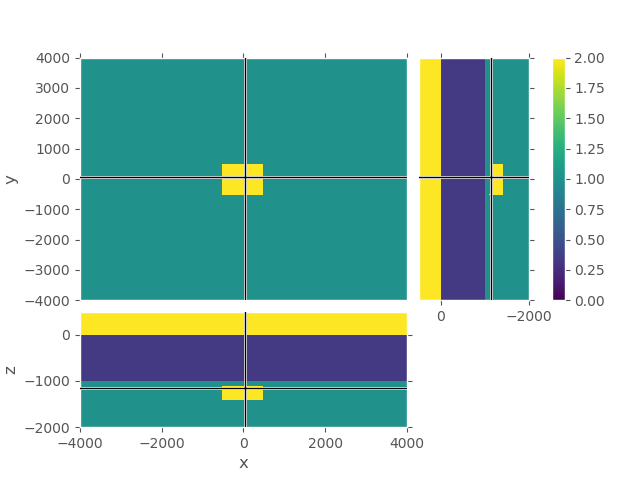

In [5]:
# Layered_background
res_x = res_air*np.ones(mesh.nC)
res_x[mesh.gridCC[:, 2] <= 0] = res_sea

res_y = res_x.copy()
res_z = res_x.copy()

res_x[mesh.gridCC[:, 2] <= -water_depth] = res_back[0]
res_y[mesh.gridCC[:, 2] <= -water_depth] = res_back[1]
res_z[mesh.gridCC[:, 2] <= -water_depth] = res_back[2]

res_x_bg = res_x.copy()
res_y_bg = res_y.copy()
res_z_bg = res_z.copy()

# Include the target
target_inds = (
    (mesh.gridCC[:, 0] >= target_x[0]) & (mesh.gridCC[:, 0] <= target_x[1]) &
    (mesh.gridCC[:, 1] >= target_y[0]) & (mesh.gridCC[:, 1] <= target_y[1]) &
    (mesh.gridCC[:, 2] >= target_z[0]) & (mesh.gridCC[:, 2] <= target_z[1])
)
res_x[target_inds] = res_target
res_y[target_inds] = res_target
res_z[target_inds] = res_target

# Create emg3d-models for given frequency
pmodel = emg3d.utils.Model(mesh, res_x, res_y, res_z, freq)
pmodel_bg = emg3d.utils.Model(mesh, res_x_bg, res_y_bg, res_z_bg, freq)

# Plot a slice
mesh.plot_3d_slicer(pmodel.res_x, zslice=-1100, clim=[0, 2],
                    xlim=(-4000, 4000), ylim=(-4000, 4000), zlim=(-2000, 500))

## Calculate `emg3d`

In [6]:
%memit em3_tg = emg3d.solver.solver(mesh, pmodel, sfield, verb=3, nu_pre=0, semicoarsening=True)


:: emg3d START :: 13:45:05 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 0, 1, 2          verb      : 3
   Original grid  :  64 x  64 x  32     => 131,072 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   5 ;   5 ;   4   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                            /
      4h_  \                  /\      / 
      8h_   \          /\    /  \    /  
     16h_    \    /\  /  \  /    \  /   
     32h_     \/\/  \/    \/      \/    

   [13:45:06]   5.227e-02  after   1 F-cycles   [2.918e-07, 0.052]   0 1
   [13:45:06]   6.108e-03  after   2 F-cycles   [3.410e-08, 0.117]   0 2
   [13:45:07]   7.462e-04  after   3 F-cycles   [4.166e-09, 0.122]   0 3
   [13:45:08]   1.133e-04  after   4 F-cycles   [6.328e-10, 0.152]   0 1
   [13:45:09]

In [7]:
%memit em3_bg = emg3d.solver.solver(mesh, pmodel_bg, sfield, verb=3, nu_pre=0, semicoarsening=True)


:: emg3d START :: 13:45:12 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 0, 1, 2          verb      : 3
   Original grid  :  64 x  64 x  32     => 131,072 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   5 ;   5 ;   4   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                            /
      4h_  \                  /\      / 
      8h_   \          /\    /  \    /  
     16h_    \    /\  /  \  /    \  /   
     32h_     \/\/  \/    \/      \/    

   [13:45:13]   5.250e-02  after   1 F-cycles   [2.931e-07, 0.052]   0 1
   [13:45:14]   6.468e-03  after   2 F-cycles   [3.611e-08, 0.123]   0 2
   [13:45:14]   8.049e-04  after   3 F-cycles   [4.494e-09, 0.124]   0 3
   [13:45:16]   1.435e-04  after   4 F-cycles   [8.012e-10, 0.178]   0 1
   [13:45:16]

## Calculate `SimPEG`

In [8]:
# Set up the PDE
prob = FDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh), Solver=Solver)

# Set up the receivers
rx_locs = Mesh.utils.ndgrid([rec_x, np.r_[0], np.r_[-water_depth]])
rx_list = [
    FDEM.Rx.Point_e(orientation='x', component="real", locs=rx_locs), 
    FDEM.Rx.Point_e(orientation='x', component="imag", locs=rx_locs)
]

# We use the emg3d-source-field, to ensure we use the same in both cases
# (the source-field of emg3d is multiplied by `j omega mu0`, so we have to 'undo' that).
src_vec = np.real(sfield.field/(2j*np.pi*pmodel.freq*emg3d.utils.mu_0))
src_sp = FDEM.Src.RawVec_e(rx_list, s_e=src_vec, freq=freq)
src_list = [src_sp]
survey = FDEM.Survey(src_list)

# Create the simulation
prob.pair(survey)

In [9]:
@contextmanager
def ctimeit(before=''):
    """Print time used by commands run within the context manager."""
    t0 = default_timer()
    yield
    t1 = default_timer() - t0
    print(f"{before}{timedelta(seconds=np.round(t1))}")

In [10]:
with ctimeit("SimPEG runtime: "):
    %memit spg_tg_dobs = survey.dpred(np.vstack([1./res_x, 1./res_y, 1./res_z]).T)
spg_tg = Data(survey, dobs=spg_tg_dobs)

peak memory: 10460.50 MiB, increment: 10133.86 MiB
SimPEG runtime: 0:05:43


In [11]:
with ctimeit("SimPEG runtime: "):
    %memit spg_bg_dobs = survey.dpred(np.vstack([1./res_x_bg, 1./res_y_bg, 1./res_z_bg]).T)
spg_bg = Data(survey, dobs=spg_bg_dobs)

peak memory: 10436.82 MiB, increment: 9706.01 MiB
SimPEG runtime: 0:04:41


## Plot result

In [12]:
ix1, ix2 = 12, 12
iy = 32
iz = 13

mesh.vectorCCx[ix1], mesh.vectorCCx[-ix2-1], mesh.vectorNy[iy], mesh.vectorNz[iz]

(-1950.0, 1950.0, 0.0, -999.9999999999991)

<IPython.core.display.Javascript object>


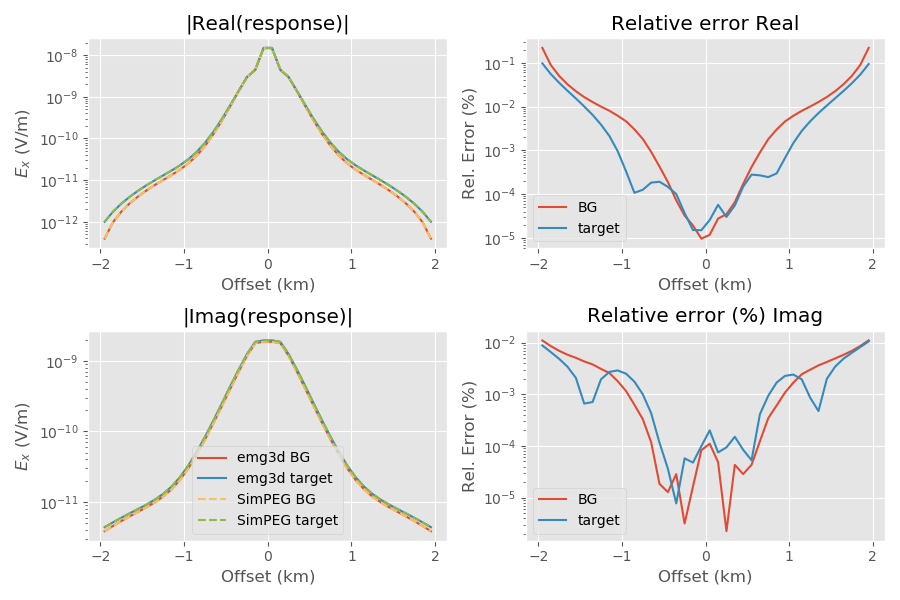

In [13]:
plt.figure(figsize=(9, 6))

plt.subplot(221)
plt.title('|Real(response)|')
plt.semilogy(rec_x/1e3, np.abs(em3_bg.fx[ix1:-ix2, iy, iz].real))
plt.semilogy(rec_x/1e3, np.abs(em3_tg.fx[ix1:-ix2, iy, iz].real))
plt.semilogy(rec_x/1e3, np.abs(spg_bg[src_sp, rx_list[0]]), 'C4--')
plt.semilogy(rec_x/1e3, np.abs(spg_tg[src_sp, rx_list[0]]), 'C5--')
plt.xlabel('Offset (km)')
plt.ylabel('$E_x$ (V/m)')

plt.subplot(223)
plt.title('|Imag(response)|')
plt.semilogy(rec_x/1e3, np.abs(em3_bg.fx[ix1:-ix2, iy, iz].imag), label='emg3d BG')
plt.semilogy(rec_x/1e3, np.abs(em3_tg.fx[ix1:-ix2, iy, iz].imag), label='emg3d target')
plt.semilogy(rec_x/1e3, np.abs(spg_bg[src_sp, rx_list[1]]), 'C4--', label='SimPEG BG')
plt.semilogy(rec_x/1e3, np.abs(spg_tg[src_sp, rx_list[1]]), 'C5--', label='SimPEG target')
plt.xlabel('Offset (km)')
plt.ylabel('$E_x$ (V/m)')
plt.legend()

plt.subplot(222)
plt.title('Relative error Real')
plt.semilogy(rec_x/1e3, 100*np.abs((spg_bg[src_sp, rx_list[0]]-em3_bg.fx[ix1:-ix2, iy, iz].real)/
                                   em3_bg.fx[ix1:-ix2, iy, iz].real), label='BG')
plt.semilogy(rec_x/1e3, 100*np.abs((spg_tg[src_sp, rx_list[0]]-em3_tg.fx[ix1:-ix2, iy, iz].real)/
                                   em3_tg.fx[ix1:-ix2, iy, iz].real), label='target')

plt.xlabel('Offset (km)')
plt.ylabel('Rel. Error (%)')
plt.legend()

plt.subplot(224)
plt.title('Relative error (%) Imag')
plt.semilogy(rec_x/1e3, 100*np.abs((spg_bg[src_sp, rx_list[1]]-em3_bg.fx[ix1:-ix2, iy, iz].imag)/
                                   em3_bg.fx[ix1:-ix2, iy, iz].imag), label='BG')
plt.semilogy(rec_x/1e3, 100*np.abs((spg_tg[src_sp, rx_list[1]]-em3_tg.fx[ix1:-ix2, iy, iz].imag)/
                                   em3_tg.fx[ix1:-ix2, iy, iz].imag), label='target')

plt.xlabel('Offset (km)')
plt.ylabel('Rel. Error (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
emg3d.Report([discretize, SimPEG, pymatsolver])

--------------------------------------------------------------------------------
  Date: Fri Jul 05 13:55:45 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.6 GB : RAM
           Jupyter : Environment

  Python 3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC 7.3.0]

             0.4.4 : discretize
            0.11.5 : SimPEG
             0.1.2 : pymatsolver
            1.16.4 : numpy
             1.2.1 : scipy
            0.44.1 : numba
             0.7.0 : emg3d
             7.6.0 : IPython
             3.1.0 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------